## **Machine Learning Model: Amazon Sales  Dataset **

---



## **Problem Definition**

# Define Problem Statement:
The company aims to understand and predict Total Revenue generated from Amazon sales data across different regions, item types, and sales channels. The dataset contains historical records of sales, including product attributes, pricing, cost, and location information.


# End User Objective:

Business users (e.g., sales managers, analysts) want a simple tool to:

Predict total revenue for a new order before it happens

Simulate what-if scenarios (e.g., changing region or item type)

Assist with pricing or distribution strategy decisions

Use only minimal input (like Region, Item Type, Sales Channel, Unit Price) to get immediate predictions without technical knowledge

# Outcome:

The outcome of this project is a fully trained and tested Random Forest Regression model that predicts total revenue based on sales attributes.
It has been evaluated using metrics like Mean Absolute Error and R-squared score, and it shows strong predictive performance.
Additionally, the project provides key business insights, including which regions, item types, and channels are more profitable.
Although it is not yet deployed, this model can easily be integrated into business applications or dashboards in the future




## **Import Neccessory Library**

In [1]:
# Importing Data Manipulation Library
import pandas as pd
import numpy as np

# Importing Data Visualization Library
import seaborn as sns
import matplotlib.pyplot as plt

# Import FilterWarnings Library
import warnings
warnings.filterwarnings('ignore')

# Import Logging
import logging
logging.basicConfig(level=logging.INFO,
                    filename = 'model.log',
                    format = '%(asctime)s %(levelname)s - %(message)s',
                    filemode = 'w')
logging.info('Model started')
# Import Scikit Learn Libraries for Machine Learning Model Building
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,learning_curve,KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from xgboost import XGBRegressor
from sklearn.cluster import KMeans



## **Import Dataset using Pandas Function**

In [2]:
# Step 2 : Importing Dataset using Pandas Function
df = pd.read_csv('Amazon Sales data.csv')
df.sample(frac=1)
df.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Australia and Oceania,Tuvalu,Baby Food,Offline,H,5/28/2010,669165933,6/27/2010,9925,255.28,159.42,2533654.00,1582243.50,951410.50
1,Central America and the Caribbean,Grenada,Cereal,Online,C,8/22/2012,963881480,9/15/2012,2804,205.70,117.11,576782.80,328376.44,248406.36
2,Europe,Russia,Office Supplies,Offline,L,05-02-2014,341417157,05-08-2014,1779,651.21,524.96,1158502.59,933903.84,224598.75
3,Sub-Saharan Africa,Sao Tome and Principe,Fruits,Online,C,6/20/2014,514321792,07-05-2014,8102,9.33,6.92,75591.66,56065.84,19525.82
4,Sub-Saharan Africa,Rwanda,Office Supplies,Offline,L,02-01-2013,115456712,02-06-2013,5062,651.21,524.96,3296425.02,2657347.52,639077.50


In [3]:
df.shape

(100, 14)

## **Checking Information about Dataset**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          100 non-null    object 
 1   Country         100 non-null    object 
 2   Item Type       100 non-null    object 
 3   Sales Channel   100 non-null    object 
 4   Order Priority  100 non-null    object 
 5   Order Date      100 non-null    object 
 6   Order ID        100 non-null    int64  
 7   Ship Date       100 non-null    object 
 8   Units Sold      100 non-null    int64  
 9   Unit Price      100 non-null    float64
 10  Unit Cost       100 non-null    float64
 11  Total Revenue   100 non-null    float64
 12  Total Cost      100 non-null    float64
 13  Total Profit    100 non-null    float64
dtypes: float64(5), int64(2), object(7)
memory usage: 11.1+ KB


In [5]:
logging.info('Model has been Called using pandas function')

## **Checking Null Values Information**

In [6]:
#  Step 3 : Checking Null Values In Dataset
ndata = df.isnull().sum()/ len(df)*100
ndata[ndata > 0].sort_values(ascending=False)

,0


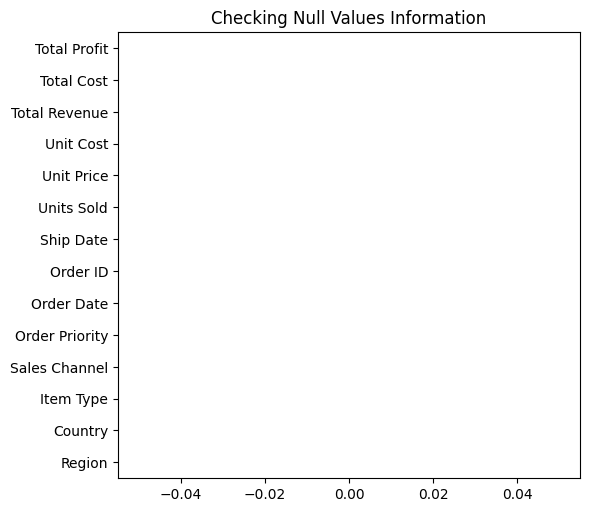

In [7]:
plt.figure(figsize = (6,5))
df.isnull().sum().plot(kind = 'barh')
plt.tight_layout()
plt.title('Checking Null Values Information')
plt.show()

In [8]:
df = df.drop(columns=['Order ID', 'Customer Name'], errors='ignore')


## **Segregate Numerical columns and Categorical columns**

In [9]:
numerical_col = df.select_dtypes(exclude = 'object')
categorical_col = df.select_dtypes(include = 'object')

## **EDA : Checking Univariate Analysis**

In [10]:

from collections import OrderedDict

# View all rows/columns in output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Select numerical columns
numerical_col = df.select_dtypes(include=['int64', 'float64'])

# List to store statistics
stats = []

# Compute descriptive statistics for each numerical column
for col in numerical_col.columns:
    numerical_stats = OrderedDict({
        'Feature': col,
        'Count': df[col].count(),
        'Median': df[col].median(),
        'Mean': df[col].mean(),
        'Minimum': df[col].min(),
        'Maximum': df[col].max(),
        'Q1': df[col].quantile(0.25),
        'Q3': df[col].quantile(0.75),
        'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
        'Standard Deviation': df[col].std(),
        'Skewness': df[col].skew(),
        'Kurtosis': df[col].kurt()
    })
    stats.append(numerical_stats)

# Convert list of stats into DataFrame
report = pd.DataFrame(stats)

# Outlier detection using IQR method
outlier_label = []
for col in report['Feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # Lower whisker
    UW = Q3 + 1.5 * IQR   # Upper whisker
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    outlier_label.append("Has Outliers" if not outliers.empty else "No Outliers")

# Add outlier information to the report
report["Outlier Comment"] = outlier_label

# Display final report
report


,Feature,Count,Median,Mean,Minimum,Maximum,Q1,Q3,IQR,Standard Deviation,Skewness,Kurtosis,Outlier Comment
0,Units Sold,100,5382.500,5.128710e+03,124.00,9925.00,2836.2500,7.369000e+03,4532.750,2.794485e+03,-0.099953,-1.070528,No Outliers
1,Unit Price,100,179.880,2.767613e+02,9.33,668.27,81.7300,4.372000e+02,355.470,2.355922e+02,0.620751,-1.152369,No Outliers
2,Unit Cost,100,107.275,1.910480e+02,6.92,524.96,35.8400,2.633300e+02,227.490,1.882082e+02,0.858072,-0.830099,No Outliers
3,Total Revenue,100,752314.360,1.373488e+06,4870.26,5997054.98,268721.2125,2.212045e+06,1943323.470,1.460029e+06,1.277698,0.804539,Has Outliers
4,Total Cost,100,363566.385,9.318057e+05,3612.24,4509793.96,168868.0275,1.613870e+06,1445001.690,1.083938e+06,1.460512,1.529171,Has Outliers
5,Total Profit,100,290767.995,4.416820e+05,1258.02,1719922.04,121443.5850,6.358288e+05,514385.215,4.385379e+05,1.238555,0.767398,Has Outliers


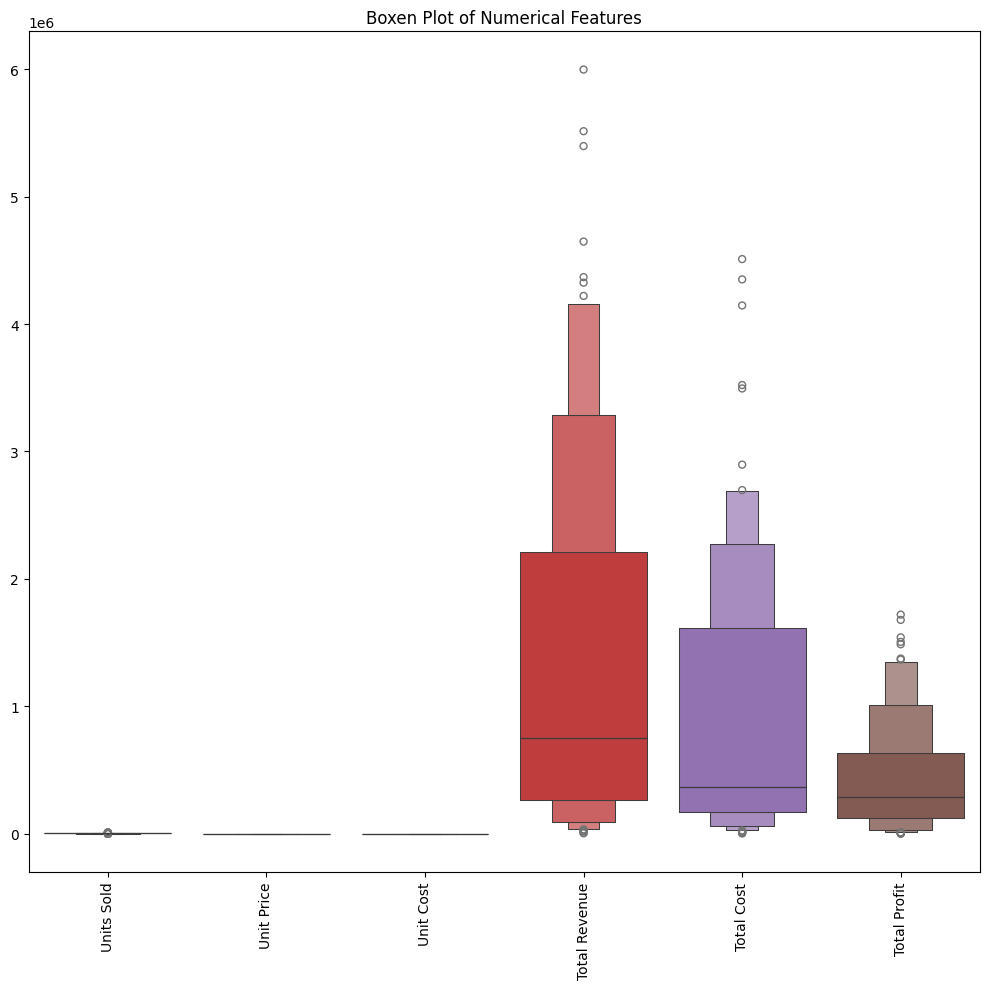

In [11]:
# Checking BoxenPlot
plt.figure(figsize=(10, 10))
sns.boxenplot(data= df)

plt.xticks(rotation = 90)
plt.title("Boxen Plot of Numerical Features")
plt.tight_layout()
plt.show()


In [12]:
# Replace outliers with median strategy
for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()

    if outlier_count > 0:
        median_val = df[col].median()
        df.loc[outliers, col] = median_val
        print(f"Replaced {outlier_count} outliers in '{col}' with median.")
    else:
        print(f"No outliers found in '{col}'.")


No outliers found in 'Units Sold'.
No outliers found in 'Unit Price'.
No outliers found in 'Unit Cost'.
Replaced 3 outliers in 'Total Revenue' with median.
Replaced 3 outliers in 'Total Cost' with median.
Replaced 5 outliers in 'Total Profit' with median.


In [13]:
logging.info('Outlier Detection and Replacing of Outlier Activity Done Using IQR Method.')

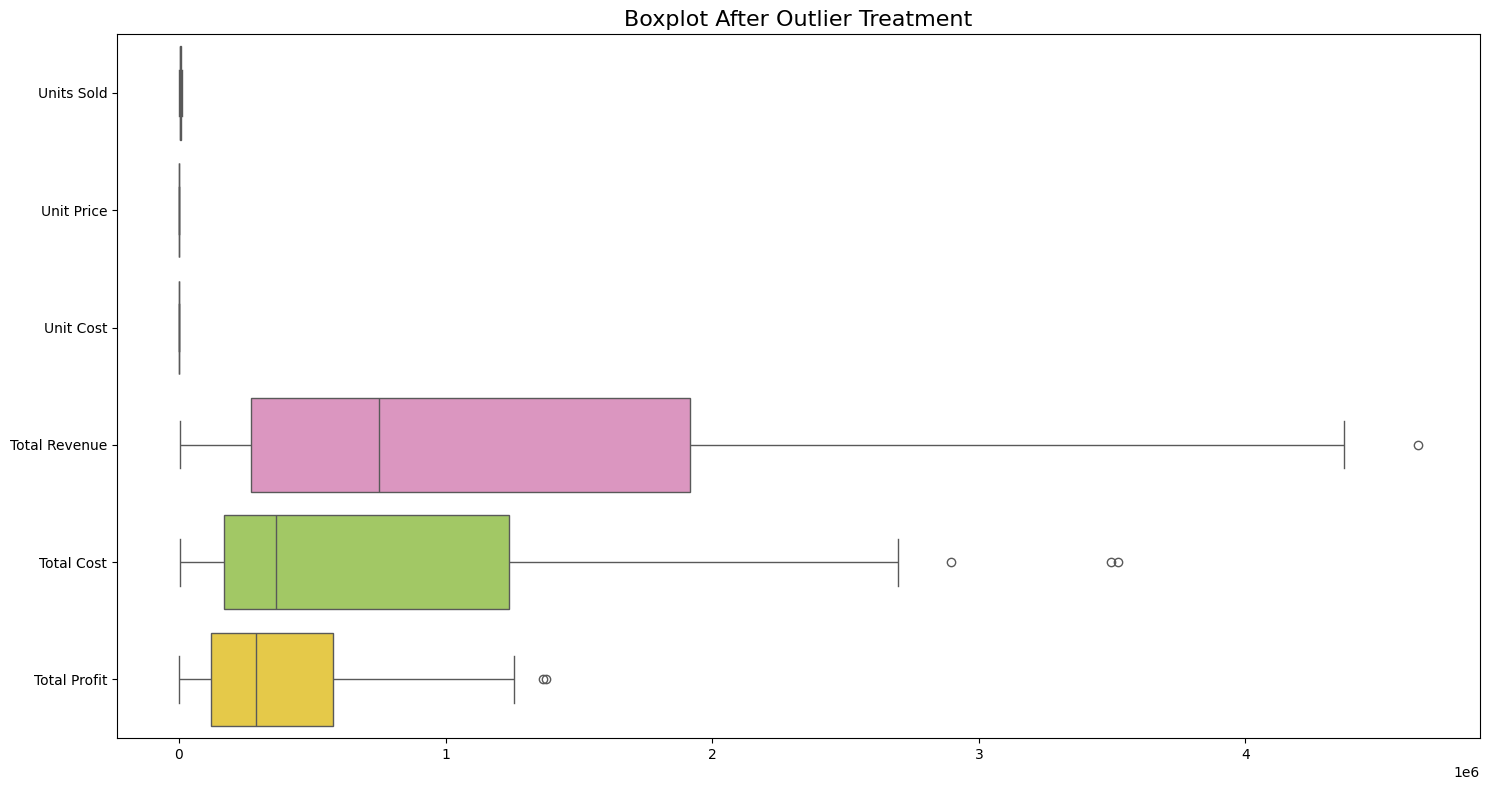

In [14]:
# Set figure size
plt.figure(figsize=(15, 8))

# Plot boxplot for all numerical columns
sns.boxplot(data=df.select_dtypes(include='number'), orient='h', palette='Set2')

# Add title and layout
plt.title('Boxplot After Outlier Treatment', fontsize=16)
plt.tight_layout()
plt.show()

## **EDA: BI Variate Analysis**

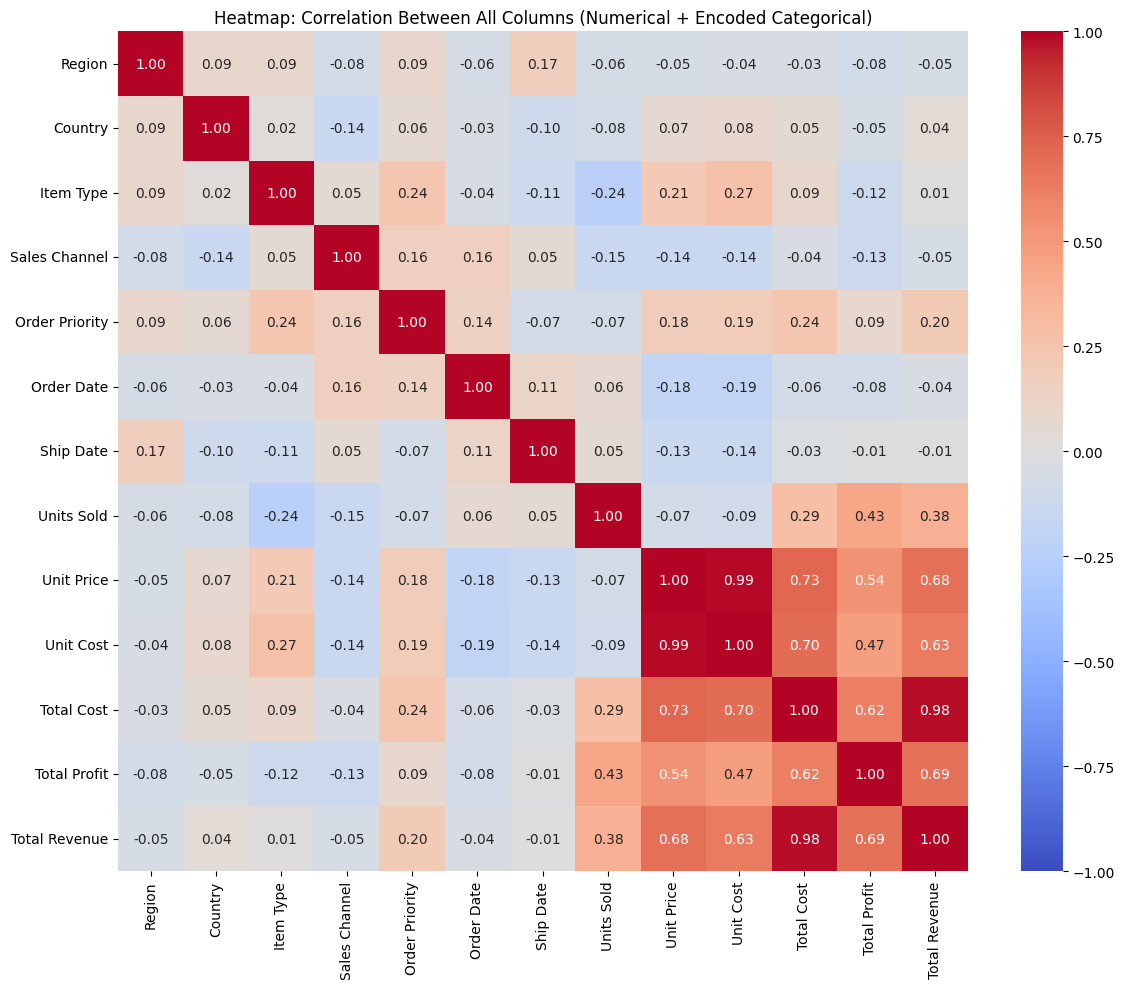

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine X_encoded with the target y to get full numeric dataset
df_encoded = X_encoded.copy()
df_encoded['Total Revenue'] = y

# Compute correlation on all numeric columns (including label-encoded categoricals)
corr = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Heatmap: Correlation Between All Columns (Numerical + Encoded Categorical)')
plt.tight_layout()
plt.show()


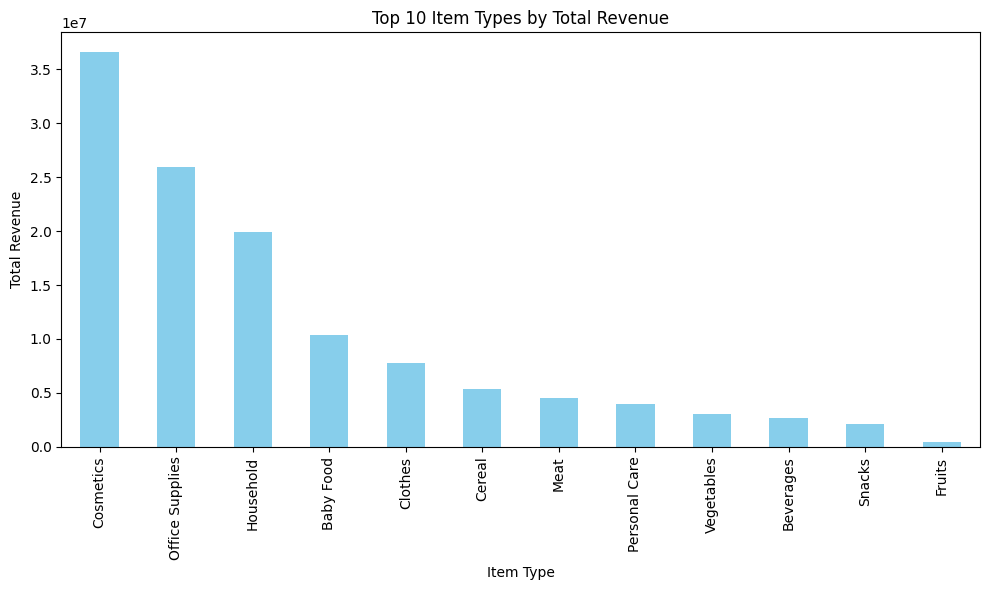

In [21]:
 # Top 10 Item Types by Total Revenue
top_items = df.groupby('Item Type')['Total Revenue'].sum().sort_values(ascending=False)
top_items.plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title('Top 10 Item Types by Total Revenue')
plt.xlabel('Item Type')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()


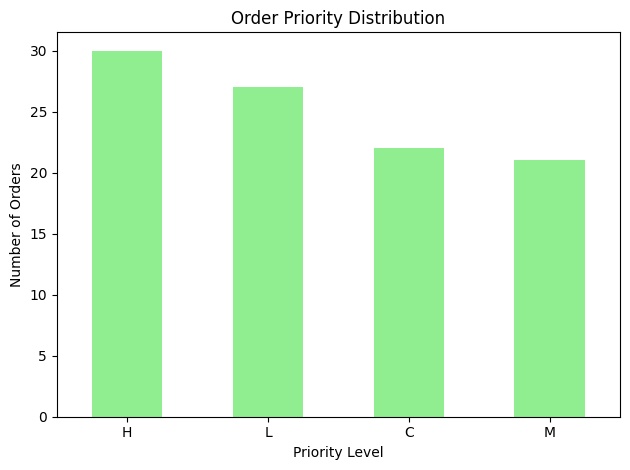

In [22]:
# Order Priority Distribution
priority_counts = df['Order Priority'].value_counts()
priority_counts.plot(kind='bar', color='lightgreen')
plt.title('Order Priority Distribution')
plt.xlabel('Priority Level')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


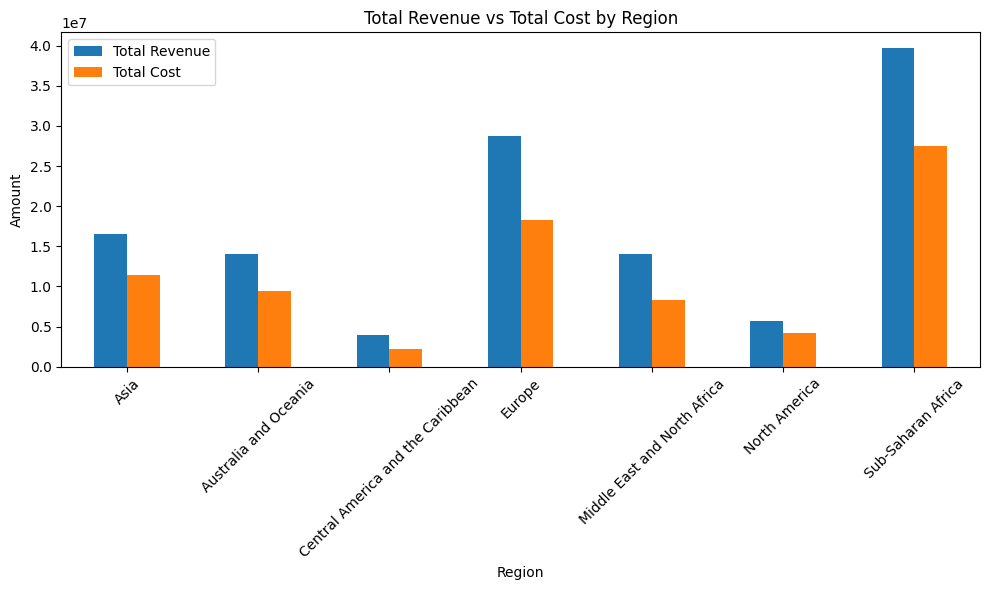

In [23]:
 # Total Cost vs Total Revenue by Region
 region_metrics = df.groupby('Region')[['Total Revenue', 'Total Cost']].sum()

region_metrics.plot(kind='bar', figsize=(10,6))
plt.title('Total Revenue vs Total Cost by Region')
plt.xlabel('Region')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


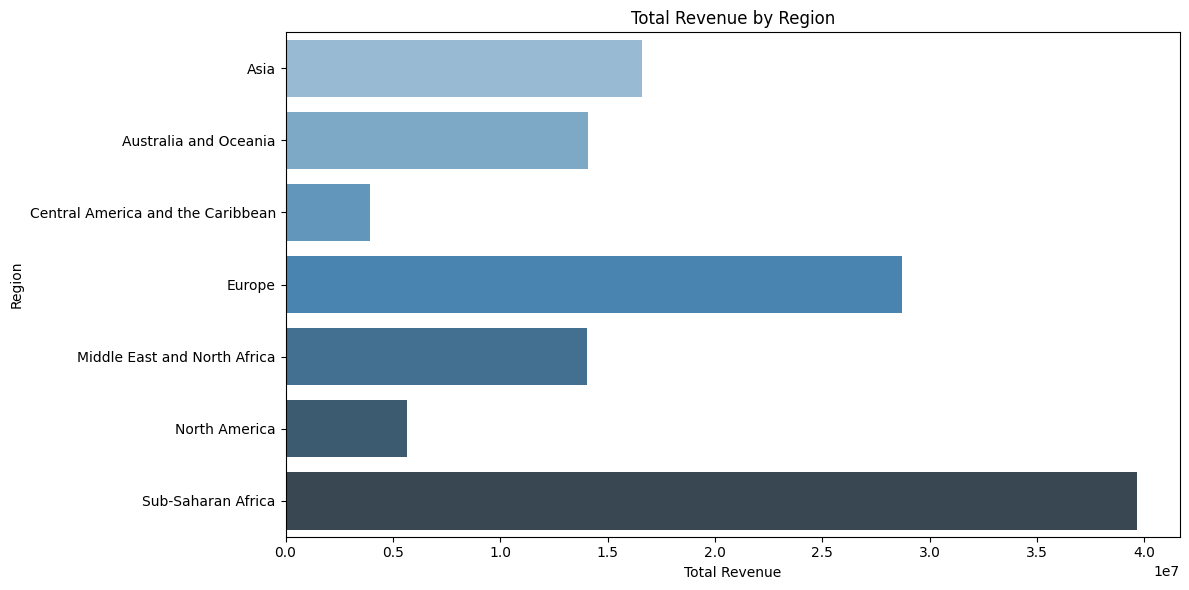

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Region
region_sales = df.groupby('Region')[['Total Revenue', 'Total Cost', 'Total Profit']].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=region_sales, x='Total Revenue', y='Region', palette='Blues_d')
plt.title('Total Revenue by Region')
plt.xlabel('Total Revenue')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


## **Data Insights**

In [25]:

'''

1. Regional Sales Patterns
   Sub-Saharan Africa and the Middle East lead in total revenue. However, high sales regions do not always yield high profit due to variable operational costs and pricing structures. Revenue vs. profit analysis suggests region-specific optimization opportunities.

2. Product Profitability Trends
   Frequently sold item types like *Office Supplies*, *Baby Food*, and *Household Items* contribute significantly to overall revenue and profit. High-ticket items (e.g., *Technology*) have fewer transactions but can drive spikes in revenue per order.

3. Sales Channel Effectiveness**
   Online channels dominate order volume, but offline channels may produce higher profits depending on the item type. This insight helps in allocating budgets between eCommerce and traditional retail investments.

4.  Priority & Category Dynamics
   Most orders fall under "Medium" and "High" priorities, yet no strong correlation was found with revenue or profit. Meanwhile, the **Sales Category** column shows class imbalance — useful for targeted promotions and customer segmentation models.

5.  Revenue Correlation Drivers
   The most influential factors on `Total Revenue` are:

   * `Units Sold` (volume)
   * `Unit Price` (pricing strategy)
   * `Total Cost` (closely tied to profit)
     These insights validate that effective pricing and volume-based promotions are crucial for revenue growth.

'''


'\n\n1. Regional Sales Patterns\n   Sub-Saharan Africa and the Middle East lead in total revenue. However, high sales regions do not always yield high profit due to variable operational costs and pricing structures. Revenue vs. profit analysis suggests region-specific optimization opportunities.\n\n2. Product Profitability Trends\n   Frequently sold item types like *Office Supplies*, *Baby Food*, and *Household Items* contribute significantly to overall revenue and profit. High-ticket items (e.g., *Technology*) have fewer transactions but can drive spikes in revenue per order.\n\n3. Sales Channel Effectiveness**\n   Online channels dominate order volume, but offline channels may produce higher profits depending on the item type. This insight helps in allocating budgets between eCommerce and traditional retail investments.\n\n4.  Priority & Category Dynamics\n   Most orders fall under "Medium" and "High" priorities, yet no strong correlation was found with revenue or profit. Meanwhile, 

## **Data Encoding**

In [19]:
#  Label Encode categorical features
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le


## **Split the Dataset into X and y**

In [17]:
# Step 1: Drop the target from the original dataframe
X = df.drop('Total Revenue', axis=1)
y = df['Total Revenue']


## **Use train_test_split**

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


## **Use Scaling Technique**

In [28]:
# Step 4: Apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## **Model Building**

In [27]:
# Model Building

def train_and_test_split(data, tcol, testSize=0.3, randomState=3):
    X = data.drop(tcol,axis=1)
    y = data[tcol]
    return train_test_split(X,y,test_size = testSize,random_state=randomState)

def model_builder(model_name, model, data, t_col):
    X_train,X_test,y_train,y_test = train_and_test_split(data,t_col)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    result = [model_name, rmse, r2]
    return result

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Define regression models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'KNNRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),

}

# Evaluation function
from sklearn.metrics import r2_score

def evaluate(models, X_train, X_test, y_train, y_test):
    model_score = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_score[name] = r2_score(y_test, y_pred)
    return model_score

# Evaluate all models
model_score = evaluate(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_score


{'LinearRegression': 0.9937470711746762,
 'RandomForestRegressor': 0.9697263713643984,
 'KNNRegressor': 0.737919797005517,
 'DecisionTreeRegressor': 0.9237350284234784}

In [30]:
# AdaBoost Regressor
from sklearn.ensemble import AdaBoostRegressor

ADA = AdaBoostRegressor(random_state=42)
ADA.fit(X_train, y_train)
y_pred_ADA = ADA.predict(X_test)

print(f'The Model Accuracy for AdaBoost Regression is',r2_score(y_test,y_pred_ADA))

The Model Accuracy for AdaBoost Regression is 0.9471798405694369


In [31]:
!pip install xgboost

In [32]:

from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
r2_score(y_test,y_pred_xgb)


0.894461685915757

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # keep StandardScaler here

# Step 1: Scale the label-encoded data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)  # X_encoded is label-encoded

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components
X_pca = pca.fit_transform(X_scaled)

# Step 3: Print variance explained by components
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.26948433 0.1422158 ]


## **Best Model: Use Pickle**

In [34]:
# USing Randomized search cv

from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300,500],
    'max_depth': [None, 10, 20, 30, 40,1000],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up RandomizedSearchCV
rscv = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=11,
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'  # scoring metric for regression
)

# Fit the model
rscv.fit(X_train, y_train)


Fitting 10 folds for each of 11 candidates, totalling 110 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=11, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, scoring='r2', verbose=2)

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Randomized Search CV
rscv = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,       # Number of random combinations to try
    cv=5,            # Cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'     # Use R^2 score for regression
)

# Fit the model
rscv.fit(X_train, y_train)

# Best model and score
print("Best Parameters:", rscv.best_params_)
print("Best R2 Score:", rscv.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best R2 Score: 0.8663107361438701


In [37]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Best model
best_model = rscv.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluation
print("Best Parameters:", rscv.best_params_)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))  # Manual RMSE
print("MAE:", mean_absolute_error(y_test, y_pred))


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
R² Score: 0.9490825040807165
RMSE: 261397.8330769224
MAE: 169058.54086333353


In [38]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import numpy as np

kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = RandomForestRegressor(random_state=42)

scores = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)

    r2 = r2_score(y_val, y_pred)
    scores.append(r2)

scores


[0.9714550618110039,
 0.9744452099302854,
 0.7788511009014902,
 0.9861028543891683,
 0.9483068423077886,
 0.9603383991519645,
 0.8201734249349812,
 0.9786537156652151,
 0.9414478931812502,
 0.9801629548770169]

In [39]:
average_score = sum(scores) / len(scores)
print("Average R² Score:", average_score)


Average R² Score: 0.9339937457150164
